In [1]:
import os

import numpy as np
import xarray as xr
import cfgrib
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from dask.distributed import Client, LocalCluster

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, "axes.labelsize":16, "axes.titlesize":16,
                     "font.weight": "bold","axes.labelweight":"bold","axes.titleweight":"bold",
                    "figure.titleweight":"bold", "figure.titlesize":"large" })

from ambiance import Atmosphere
from aostools import climate

from Eval import plot_map_xr, plot_profile_xr, plot_time_profile_xr, make_gif
from Eval import var_info, coord_info, results_dir


In [2]:
dateset_name = {
    'icon':'ICON',
    'era5':'ERA5',
    'geos':'GEOS-FP',
    'geos_vmfc':'GEOS-FP'
}

# Open dataset

In [3]:
dataset_i = 'icon'
dataset_e = 'era5'
dataset_g = 'geos'
dataset_g_vmfc = 'geos_vmfc'

In [4]:
data_dir = '/gemeinsam_tmp/SSW_2021/'

In [5]:
#client = Client(LocalCluster(host='192.168.154.3')) # change to ora's IP adress: 192.168.135.33
client = Client(LocalCluster(host='192.168.155.33'))

In [6]:
client

Client Scheduler: tcp://192.168.155.33:38367 Dashboard: http://192.168.155.33:8787/status,Cluster Workers: 8 Cores: 64 Memory: 810.22 GB


## GEOS-FP

In [7]:
infiles = f'{data_dir}/geos-fp/geos5_subset*.nc'
ds_geos = xr.open_mfdataset(
    infiles,
    combine='nested',
    concat_dim = 'time',
    parallel = True,
)

In [8]:
wrong_idx = [300, 250, 200, 150]
for i in wrong_idx:
    ds_geos = ds_geos.where(ds_geos.lev != i, drop=True )

/home/ap1_12/.conda/envs/nwp-py3/lib/python3.6/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/ap1_12/.conda/envs/nwp-py3/lib/python3.6/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/hom

## ERA5

In [9]:
infiles = f'{data_dir}ERA5/*.grib'
ds_era5 = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
)

## ICON

In [10]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{data_dir}dwd/analysis_new/igar??????????'
ds_icon = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={'filter_by_keys': filter_by_keys},
)

## Define markant time points

In [11]:
tt_SSW = np.datetime64('2021-01-04T18')
tt_GWF = np.datetime64('2020-12-26T00')

### Wind Profiles

In [ ]:
p = ds_icon['u'].sel(
    isobaricInhPa=10,
    latitude = 60,
    method = 'nearest'
).mean('longitude').plot(x = 'time', label = 'ICON', lw = 3)

ax = p[0].axes

ds_era5['u'].sel(
    isobaricInhPa=10,
    latitude = 60,
    method = 'nearest'
).mean('longitude').plot(x = 'time', ax = ax, label = 'ERA5', alpha = 0.7)


ds_geos['u'].sel(
    lev=10,
    lat = 60,
).mean('lon').plot(x = 'time', ax = ax, label = 'GEOS-FP', alpha = 0.5)

ax.legend()
ax.grid()

In [ ]:
var = 't'
p_level = 10

x_i = (ds_icon[var].sel(
    isobaricInhPa=p_level,
    latitude = 60,
).mean('longitude') - 273.15).compute()
x_i = x_i.rename('tc')

x_e = (ds_era5[var].sel(
    isobaricInhPa=p_level,
    latitude = 60,
).mean('longitude') - 273.15).compute()
x_e = x_e.rename('tc')

x_g = (ds_geos[var].sel(
    lev=p_level,
    lat = 60,
).mean('lon') - 273.15).compute() 
x_g = x_g.rename('tc')

In [ ]:
fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)


ax.plot(x_i.time, x_i,
        label = 'ICON', lw = 3)

ax.plot(x_e.time, x_e,
        label = 'ERA5', alpha = 0.5)

ax.plot(x_g.time, x_g,
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')
ax.axvline(x = tt_GWF, color = 'g', label = 'GWF')


ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'$\overline{T} \,\,\,\,$' + r'$[^\circ C]$')
ax.set_title('Zonal Mean Temperature: 10hPa | 60°N ')


pass

In [ ]:
var = 'u'
x2_i = ds_icon[var].sel(
    #isobaricInhPa = 10,
    latitude = 60,
).mean('longitude').compute()

In [ ]:
var = 'u'
x2_e = ds_era5[var].sel(
    #isobaricInhPa=10,
    latitude = 60,
).mean('longitude').compute()

In [ ]:
var = 'u'
x2_g = ds_geos[var].sel(
    #lev=10,
    lat = 60,
).mean('lon').compute()

In [ ]:
plot_time_profile_xr(x2_e, dataset_e,  mode='meridional', average=False,
                    norm_bound=None, norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=20,
                    save=False, title = 'ERA5: Zonal Mean Zonal Wind \n 60°N')

In [ ]:
var = 't'
x2_e = (ds_era5[var].sel(
    #isobaricInhPa=10,
    latitude = 60,
).mean('longitude') - 273.15).compute()

x2_e = x2_e.rename('tc')

In [ ]:
x2_e.min(), x2_e.max()

In [ ]:
plot_time_profile_xr(x2_e, dataset_e,  mode='meridional', average=False,
                    norm_bound=None, norm_type = 'linear', 
                    cmap = plt.cm.Blues_r, levels=20,
                    save=False, title = 'ERA5: Zonal Mean Temperature \n 60°N')

In [ ]:
x2_e

# EP Flux 

### Compote EP Eddy Heat

#### icon ~3 min

In [12]:
data_i = ds_icon.sel(
    **{coord_info.get(dataset_i).get('p'): slice(350, 1)},
    **{coord_info.get(dataset_i).get('lat'): slice(45, 75)}
       ).load()

In [13]:
ep1_i, ep2_i, ep1_div_i, ep2_div_i = climate.ComputeEPfluxDivXr(data_i['u'], data_i['v'], data_i['t'],
                lat=coord_info.get(dataset_i).get('lat'), lon=coord_info.get(dataset_i).get('lon'),
                pres=coord_info.get(dataset_i).get('p'), time=coord_info.get(dataset_i).get('time') )

ep_div_i = ep1_div_i + ep2_div_i

ep1_i.name = 'EP1'
ep2_i.name = 'EP2'
ep1_div_i.name = 'EP1_div'
ep2_div_i.name = 'EP2_div'
ep_div_i.name = 'EP_div'

In [14]:
ep2_i_w = ep2_i
coslat_weights = np.cos(np.deg2rad(ep2_i_w[coord_info.get(dataset_i).get('lat')]))
coslat_weights.name = "weights"
ep2_i_w = ep2_i_w.weighted(coslat_weights)
ep2_i_w = ep2_i_w.mean(dim = coord_info.get(dataset_i).get('lat'))

In [15]:
ep1_i_w = ep1_i
coslat_weights = np.cos(np.deg2rad(ep1_i_w[coord_info.get(dataset_i).get('lat')]))
coslat_weights.name = "weights"
ep1_i_w = ep1_i_w.weighted(coslat_weights)
ep1_i_w = ep1_i_w.mean(dim = coord_info.get(dataset_i).get('lat'))

In [16]:
ep1_div_i_w = ep1_div_i
coslat_weights = np.cos(np.deg2rad(ep1_div_i_w[coord_info.get(dataset_i).get('lat')]))
coslat_weights.name = "weights"
ep1_div_i_w = ep1_div_i_w.weighted(coslat_weights)
ep1_div_i_w = ep1_div_i_w.mean(dim = coord_info.get(dataset_i).get('lat'))

In [17]:
ep2_div_i_w = ep2_div_i
coslat_weights = np.cos(np.deg2rad(ep2_div_i_w[coord_info.get(dataset_i).get('lat')]))
coslat_weights.name = "weights"
ep2_div_i_w = ep2_div_i_w.weighted(coslat_weights)
ep2_div_i_w = ep2_div_i_w.mean(dim = coord_info.get(dataset_i).get('lat'))

In [18]:
ep_div_i_w = ep_div_i
coslat_weights = np.cos(np.deg2rad(ep_div_i_w[coord_info.get(dataset_i).get('lat')]))
coslat_weights.name = "weights"
ep_div_i_w = ep_div_i_w.weighted(coslat_weights)
ep_div_i_w = ep_div_i_w.mean(dim = coord_info.get(dataset_i).get('lat'))

#### era5 ~5 min

In [19]:
data_e = ds_era5.sel(
    **{coord_info.get(dataset_e).get('p'): slice(350, 1)},
    **{coord_info.get(dataset_e).get('lat'): slice(75, 45)}
       ).load()

In [20]:
ep1_e, ep2_e, ep1_div_e, ep2_div_e = climate.ComputeEPfluxDivXr(data_e['u'], data_e['v'], data_e['t'],
                lat=coord_info.get(dataset_e).get('lat'), lon=coord_info.get(dataset_e).get('lon'),
                pres=coord_info.get(dataset_e).get('p'), time=coord_info.get(dataset_e).get('time') )

ep_div_e = ep1_div_e + ep2_div_e

ep1_e.name = 'EP1'
ep2_e.name = 'EP2'
ep1_div_e.name = 'EP1_div'
ep2_div_e.name = 'EP2_div'
ep_div_e.name = 'EP_div'

In [21]:
ep2_e_w = ep2_e
coslat_weights = np.cos(np.deg2rad(ep2_e_w[coord_info.get(dataset_e).get('lat')]))
coslat_weights.name = "weights"
ep2_e_w = ep2_e_w.weighted(coslat_weights)
ep2_e_w = ep2_e_w.mean(dim = coord_info.get(dataset_e).get('lat'))

In [22]:
ep1_e_w = ep1_e
coslat_weights = np.cos(np.deg2rad(ep1_e_w[coord_info.get(dataset_e).get('lat')]))
coslat_weights.name = "weights"
ep1_e_w = ep1_e_w.weighted(coslat_weights)
ep1_e_w = ep1_e_w.mean(dim = coord_info.get(dataset_e).get('lat'))

In [23]:
ep1_div_e_w = ep1_div_e
coslat_weights = np.cos(np.deg2rad(ep1_div_e_w[coord_info.get(dataset_e).get('lat')]))
coslat_weights.name = "weights"
ep1_div_e_w = ep1_div_e_w.weighted(coslat_weights)
ep1_div_e_w = ep1_div_e_w.mean(dim = coord_info.get(dataset_e).get('lat'))

In [24]:
ep2_div_e_w = ep2_div_e
coslat_weights = np.cos(np.deg2rad(ep2_div_e_w[coord_info.get(dataset_e).get('lat')]))
coslat_weights.name = "weights"
ep2_div_e_w = ep2_div_e_w.weighted(coslat_weights)
ep2_div_e_w = ep2_div_e_w.mean(dim = coord_info.get(dataset_e).get('lat'))

In [25]:
ep_div_e_w = ep_div_e
coslat_weights = np.cos(np.deg2rad(ep_div_e_w[coord_info.get(dataset_e).get('lat')]))
coslat_weights.name = "weights"
ep_div_e_w = ep_div_e_w.weighted(coslat_weights)
ep_div_e_w = ep_div_e_w.mean(dim = coord_info.get(dataset_e).get('lat'))

#### geos ~1 min

In [26]:
data_g = ds_geos.sel(
    **{coord_info.get(dataset_g).get('p'): slice(350, 1)},
    **{coord_info.get(dataset_g).get('lat'): slice(45, 75)}
       ).load()

In [27]:
ep1_g, ep2_g, ep1_div_g, ep2_div_g = climate.ComputeEPfluxDivXr(data_g['u'], data_g['v'], data_g['t'],
                lat=coord_info.get(dataset_g).get('lat'), lon=coord_info.get(dataset_g).get('lon'),
                pres=coord_info.get(dataset_g).get('p'), time=coord_info.get(dataset_g).get('time') )

ep_div_g = ep1_div_g + ep2_div_g

ep1_g.name = 'EP1'
ep2_g.name = 'EP2'
ep1_div_g.name = 'EP1_div'
ep2_div_g.name = 'EP2_div'
ep_div_g.name = 'EP_div'

In [28]:
ep2_g_w = ep2_g
coslat_weights = np.cos(np.deg2rad(ep2_g_w[coord_info.get(dataset_g).get('lat')]))
coslat_weights.name = "weights"
ep2_g_w = ep2_g_w.weighted(coslat_weights)
ep2_g_w = ep2_g_w.mean(dim = coord_info.get(dataset_g).get('lat'))

In [29]:
ep1_g_w = ep1_g
coslat_weights = np.cos(np.deg2rad(ep1_g_w[coord_info.get(dataset_g).get('lat')]))
coslat_weights.name = "weights"
ep1_g_w = ep1_g_w.weighted(coslat_weights)
ep1_g_w = ep1_g_w.mean(dim = coord_info.get(dataset_g).get('lat'))

In [30]:
ep1_div_g_w = ep1_div_g
coslat_weights = np.cos(np.deg2rad(ep1_div_g_w[coord_info.get(dataset_g).get('lat')]))
coslat_weights.name = "weights"
ep1_div_g_w = ep1_div_g_w.weighted(coslat_weights)
ep1_div_g_w = ep1_div_g_w.mean(dim = coord_info.get(dataset_g).get('lat'))

In [31]:
ep2_div_g_w = ep2_div_g
coslat_weights = np.cos(np.deg2rad(ep2_div_g_w[coord_info.get(dataset_g).get('lat')]))
coslat_weights.name = "weights"
ep2_div_g_w = ep2_div_g_w.weighted(coslat_weights)
ep2_div_g_w = ep2_div_g_w.mean(dim = coord_info.get(dataset_g).get('lat'))

In [32]:
ep_div_g_w = ep_div_g
coslat_weights = np.cos(np.deg2rad(ep_div_g_w[coord_info.get(dataset_g).get('lat')]))
coslat_weights.name = "weights"
ep_div_g_w = ep_div_g_w.weighted(coslat_weights)
ep_div_g_w = ep_div_g_w.mean(dim = coord_info.get(dataset_g).get('lat'))

### plotting

In [41]:
p_level = 10

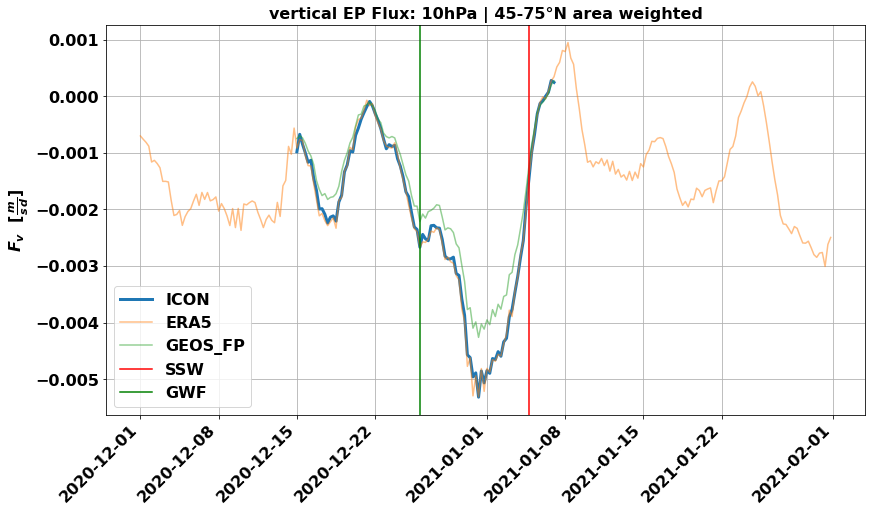

In [45]:
fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)

ax.plot(ep2_i_w.time,
        ep2_i_w.sel(**{coord_info.get(dataset_i).get('p'): p_level}),
        label = 'ICON', lw = 3)

ax.plot(ep2_e_w.time,
        ep2_e_w.sel(**{coord_info.get(dataset_e).get('p'): p_level}),
        label = 'ERA5', alpha = 0.5)

ax.plot(ep2_g_w.time,
        ep2_g_w.sel(**{coord_info.get(dataset_g).get('p'): p_level}),
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')
ax.axvline(x = tt_GWF, color = 'g', label = 'GWF')

ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'$F_v \,\,\,\,$' + r'$[\frac{m}{s \, d}]$')
ax.set_title('vertical EP Flux: 10hPa | 45-75°N area weighted')

pass

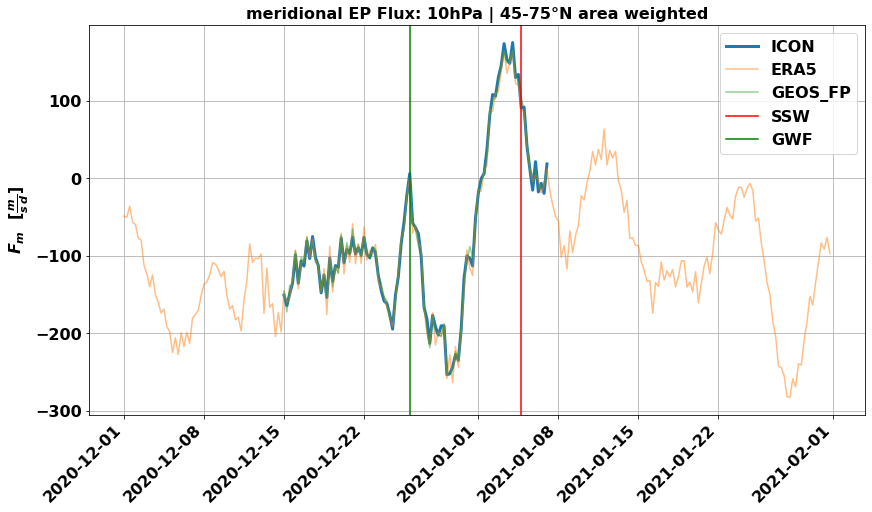

In [43]:
fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)

ax.plot(ep1_i_w.time,
        ep1_i_w.sel(**{coord_info.get(dataset_i).get('p'): p_level}),
        label = 'ICON', lw = 3)

ax.plot(ep1_e_w.time,
        ep1_e_w.sel(**{coord_info.get(dataset_e).get('p'): p_level}),
        label = 'ERA5', alpha = 0.5)

ax.plot(ep1_g_w.time,
        ep1_g_w.sel(**{coord_info.get(dataset_g).get('p'): p_level}),
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')
ax.axvline(x = tt_GWF, color = 'g', label = 'GWF')

ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'$F_m \,\,\,\,$' + r'$[\frac{m}{s \, d}]$')
ax.set_title('meridional EP Flux: 10hPa | 45-75°N area weighted')

pass

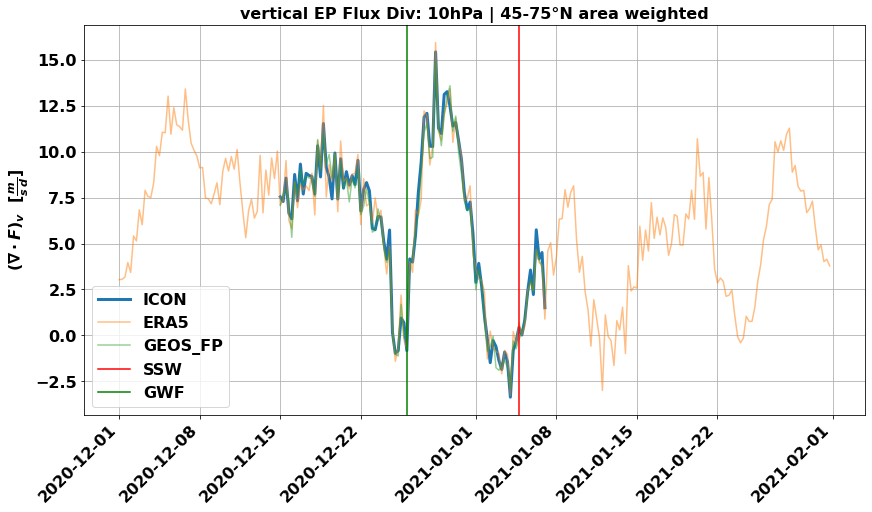

In [44]:
fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)

ax.plot(ep1_div_i_w.time,
        ep1_div_i_w.sel(**{coord_info.get(dataset_i).get('p'): p_level}),
        label = 'ICON', lw = 3)

ax.plot(ep1_div_e_w.time,
        ep1_div_e_w.sel(**{coord_info.get(dataset_e).get('p'): p_level}),
        label = 'ERA5', alpha = 0.5)

ax.plot(ep1_div_g_w.time,
        ep1_div_g_w.sel(**{coord_info.get(dataset_g).get('p'): p_level}),
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')
ax.axvline(x = tt_GWF, color = 'g', label = 'GWF')

ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'$(\nabla \cdot F)_v \,\,\,\,$' + r'$[\frac{m}{s \, d}]$')
ax.set_title('vertical EP Flux Div: 10hPa | 45-75°N area weighted')

pass

In [ ]:
fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)

ax.plot(ep2_div_i_w.time,
        ep2_div_i_w.sel(**{coord_info.get(dataset_i).get('p'): p_level}),
        label = 'ICON', lw = 3)

ax.plot(ep2_div_e_w.time,
        ep2_div_e_w.sel(**{coord_info.get(dataset_e).get('p'): p_level}),
        label = 'ERA5', alpha = 0.5)

ax.plot(ep2_div_g_w.time,
        ep2_div_g_w.sel(**{coord_info.get(dataset_g).get('p'): p_level}),
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')
ax.axvline(x = tt_GWF, color = 'g', label = 'GWF')

ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'$(\nabla \cdot F)_m \,\,\,\,$' + r'$[\frac{m}{s \, d}]$')
ax.set_title('meridional EP Flux Div: 10hPa | 45-75°N area weighted')

pass

In [ ]:
fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)

ax.plot(ep_div_i_w.time,
        ep_div_i_w.sel(**{coord_info.get(dataset_i).get('p'): p_level}),
        label = 'ICON', lw = 3)

ax.plot(ep_div_e_w.time,
        ep_div_e_w.sel(**{coord_info.get(dataset_e).get('p'): p_level}),
        label = 'ERA5', alpha = 0.5)

ax.plot(ep_div_g_w.time,
        ep_div_g_w.sel(**{coord_info.get(dataset_g).get('p'): p_level}),
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')

ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'$(\nabla \cdot F)_m + (\nabla \cdot F)_v \,\,\,\,$' + r'$[\frac{m}{s \, d}]$')
ax.set_title('EP Flux Div: 10hPa | 45-75°N area weighted')

pass

### Time Profiles

In [ ]:
p_level_d = 350

ep_div_icon_time_60 = ep_div_i.sel(**{coord_info.get(dataset_i).get('lat'): 60},
                                 **{coord_info.get(dataset_i).get('p'): slice(p_level_d,1)})
ep_div_icon_time_w = ep_div_i_w

ep_div_era5_time_60 = ep_div_e.sel(**{coord_info.get(dataset_e).get('lat'): 60},
                                 **{coord_info.get(dataset_e).get('p'): slice(p_level_d,1)})
ep_div_era5_time_w = ep_div_e_w

ep_div_geos_time_60 = ep_div_g.sel(**{coord_info.get(dataset_g).get('lat'): 60},
                                 **{coord_info.get(dataset_g).get('p'): slice(p_level_d,1)})
ep_div_geos_time_w = ep_div_g_w

In [ ]:
mini = min([ep_div_icon_time_60.min().data, ep_div_icon_time_w.min().data,
            ep_div_era5_time_60.min().data, ep_div_era5_time_w.min().data,
            ep_div_geos_time_60.min().data, ep_div_geos_time_w.min().data])

maxi = max([ep_div_icon_time_60.max().data, ep_div_icon_time_w.max().data,
            ep_div_era5_time_60.max().data, ep_div_era5_time_w.max().data,
            ep_div_geos_time_60.max().data, ep_div_geos_time_w.max().data])

In [ ]:
norm_type = 'diverging'
#norm_type = 'symlog'
linthresh=10. 
linscale=1.0 
base=np.e

### icon

In [ ]:
plot_time_profile_xr(ep_div_icon_time_60, dataset_i,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=50,
                    save=False, title = 'ICON: EP Flux Divergence \n 60°N')

In [ ]:
plot_time_profile_xr(ep_div_icon_time_w, dataset_i,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=50,
                    save=False, title = 'ICON: EP Flux Divergence \n 45-75°N area weighted')

### era5

In [ ]:
plot_time_profile_xr(ep_div_era5_time_60, dataset_e,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=50,
                    save=False, title = 'ERA5: EP Flux Divergence \n 60°N')

In [ ]:
plot_time_profile_xr(ep_div_era5_time_w, dataset_i,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=50,
                    save=False, title = 'ERA5: EP Flux Divergence \n 45-75°N area weighted')

### geos

In [ ]:
plot_time_profile_xr(ep_div_geos_time_60, dataset_g,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=50,
                    save=False, title = 'GEOS-FP: EP Flux Divergence \n 60°N')

In [ ]:
plot_time_profile_xr(ep_div_geos_time_w, dataset_g,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=50,
                    save=False, title = 'GEOS-FP: EP Flux Divergence \n 45-75°N area weighted')

# VMFC

#### icon

In [ ]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{data_dir}dwd/analysis_new/vmfc_20201215_20210107.nc'
vmfc_icon = xr.open_mfdataset(
    infiles,
    #engine='cfgrib',
    #combine='nested',
    #concat_dim = 'time',
    parallel = True,
    #backend_kwargs={'filter_by_keys': filter_by_keys},
).load()

In [ ]:
vmfc_icon_w = vmfc_icon.sel(**{coord_info.get(dataset_i).get('lat'): slice(45, 75)})
coslat_weights = np.cos(np.deg2rad(vmfc_icon_w[coord_info.get(dataset_i).get('lat')]))
coslat_weights.name = "weights"
vmfc_icon_w = vmfc_icon_w.weighted(coslat_weights)
vmfc_icon_w = vmfc_icon_w.mean(dim = coord_info.get(dataset_i).get('lat'))

#### era5

In [ ]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{data_dir}ERA5/vmfc_20201201_20210131.nc'
vmfc_era5 = xr.open_mfdataset(
    infiles,
    #engine='cfgrib',
    #combine='nested',
    #concat_dim = 'time',
    parallel = True,
    #backend_kwargs={'filter_by_keys': filter_by_keys},
).load()

In [ ]:
vmfc_era5_w = vmfc_era5.sel(**{coord_info.get(dataset_e).get('lat'): slice(75, 45)})
coslat_weights = np.cos(np.deg2rad(vmfc_era5_w[coord_info.get(dataset_e).get('lat')]))
coslat_weights.name = "weights"
vmfc_era5_w = vmfc_era5_w.weighted(coslat_weights)
vmfc_era5_w = vmfc_era5_w.mean(dim = coord_info.get(dataset_e).get('lat'))

#### geos

In [ ]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{data_dir}geos-fp/vmfc_20201215_20210107.nc'
vmfc_geos = xr.open_mfdataset(
    infiles,
    #engine='cfgrib',
    #combine='nested',
    #concat_dim = 'time',
    parallel = True,
    #backend_kwargs={'filter_by_keys': filter_by_keys},
).load()


In [ ]:
vmfc_geos_w = vmfc_geos.sel(**{coord_info.get('era5').get('lat'): slice(45, 75)})
coslat_weights = np.cos(np.deg2rad(vmfc_geos_w[coord_info.get('era5').get('lat')]))
coslat_weights.name = "weights"
vmfc_geos_w = vmfc_geos_w.weighted(coslat_weights)
vmfc_geos_w = vmfc_geos_w.mean(dim = coord_info.get('era5').get('lat'))

### Plots

In [ ]:
test = vmfc_geos['vmfc'].sel(**{coord_info.get('era5').get('lat'): 60},
                        **{coord_info.get('era5').get('p'): 1},)

In [ ]:
test.plot()

### time plots

In [ ]:
p_level_d = 1000

vmfc_geos_time_60 = vmfc_geos['vmfc'].sel(**{coord_info.get(dataset_g_vmfc).get('lat'): 60},
                             **{coord_info.get(dataset_g_vmfc).get('p'): slice(p_level_d,1)})
vmfc_geos_time_w = vmfc_geos_w['vmfc']

vmfc_era5_time_60 = vmfc_era5['vmfc'].sel(**{coord_info.get(dataset_e).get('lat'): 60},
                             **{coord_info.get(dataset_e).get('p'): slice(p_level_d,1)})
vmfc_era5_time_w = vmfc_era5_w['vmfc']

vmfc_icon_time_60 = vmfc_icon['vmfc'].sel(**{coord_info.get(dataset_i).get('lat'): 60},
                             **{coord_info.get(dataset_i).get('p'): slice(p_level_d,1)})
vmfc_icon_time_w = vmfc_icon_w['vmfc']

In [ ]:
mini = min([vmfc_geos_time_60.min().data, vmfc_geos_time_w.min().data,
            vmfc_era5_time_60.min().data, vmfc_era5_time_w.min().data,
            vmfc_icon_time_60.min().data, vmfc_icon_time_w.min().data])

maxi = max([vmfc_geos_time_60.max().data, vmfc_geos_time_w.max().data,
            vmfc_era5_time_60.max().data, vmfc_era5_time_w.max().data,
            vmfc_icon_time_60.max().data, vmfc_icon_time_w.max().data])

In [ ]:
norm_type = 'symlog'
linthresh=0.1 
linscale=1.0 
base=np.e

### icon

In [ ]:
plot_time_profile_xr(vmfc_icon_time_60, dataset_i,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                     linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=20,
                    save=False, title = 'ICON: Vetical Momentum Flux Convergence \n 60°N')

In [ ]:
plot_time_profile_xr(vmfc_icon_time_w, dataset_i,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                     linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=20,
                    save=False, title = 'ICON: Vetical Momentum Flux Convergence \n 45-75°N area weighted')

### era5

In [ ]:
plot_time_profile_xr(vmfc_era5_time_60, dataset_e,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type,
                     linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=20,
                    save=False, title = 'ERA5: Vetical Momentum Flux Convergence \n 60°N')

In [ ]:
plot_time_profile_xr(vmfc_era5_time_w, dataset_e,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                     linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=20,
                    save=False, title = 'ERA5: Vetical Momentum Flux Convergence \n 45-75°N area weighted')

### geos

In [ ]:
plot_time_profile_xr(vmfc_geos_time_60, dataset_g_vmfc,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=20,
                    save=False, title = 'GEOS-FP: Vetical Momentum Flux Convergence \n 60°N')

In [ ]:
plot_time_profile_xr(vmfc_geos_time_w, dataset_g_vmfc,  mode='meridional', average=False, mark_time=True,
                    norm_bound=(mini,maxi), norm_type = norm_type, 
                    linthresh=linthresh, linscale=linscale, base=base,
                    cmap = plt.cm.PuOr, levels=20,
                    save=False, title = 'GEOS-FP: Vetical Momentum Flux Convergence \n 45-75°N area weighted')

## level time plots

In [ ]:
p_level = 1

fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)

ax.plot(vmfc_icon.time,
        vmfc_icon['vmfc'].sel(**{coord_info.get(dataset_i).get('p'): p_level},
                     **{coord_info.get(dataset_i).get('lat'): 60}),
        label = 'ICON', lw = 3)

ax.plot(vmfc_era5.time,
        vmfc_era5['vmfc'].sel(**{coord_info.get(dataset_e).get('p'): p_level},
                     **{coord_info.get(dataset_e).get('lat'): 60}),
        label = 'ERA5', alpha = 0.5)

ax.plot(vmfc_geos.time,
        vmfc_geos['vmfc'].sel(**{coord_info.get('era5').get('p'): p_level},
                     **{coord_info.get('era5').get('lat'): 60}),
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')
#ax.axvline(x = tt_GWF, color = 'g', label = 'GWF')

ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'vmfc ' + r'$[\frac{m}{s \, d}]$')
ax.set_title('Vertical Momentum Flux Convergence: ' +str(p_level)+'hPa | 60°N ')

pass

In [ ]:
p_level = 1

fig, ax = plt.subplots(figsize=(12,7), constrained_layout=True)

ax.plot(vmfc_icon_w.time,
        vmfc_icon_w['vmfc'].sel(**{coord_info.get(dataset_i).get('p'): p_level}),
        label = 'ICON', lw = 3)

ax.plot(vmfc_era5_w.time,
        vmfc_era5_w['vmfc'].sel(**{coord_info.get(dataset_e).get('p'): p_level}),
        label = 'ERA5', alpha = 0.5)

ax.plot(vmfc_geos_w.time,
        vmfc_geos_w['vmfc'].sel(**{coord_info.get('era5').get('p'): p_level}),
        label = 'GEOS_FP', alpha = 0.5)


ax.axvline(x = tt_SSW, color = 'r', label = 'SSW')
ax.axvline(x = tt_GWF, color = 'g', label = 'GWF')

ax.grid()
ax.legend()

for label in ax.xaxis.get_majorticklabels():
    label.set_rotation(45)
    label.set_ha('right')

    
#ax.set_xlabel('time')
ax.set_ylabel(r'vmfc ' + r'$[\frac{m}{s \, d}]$')
ax.set_title('Vertical Momentum Flux Convergence: '+str(p_level)+'hPa | 45-75°N area weighted')

pass

### meridional profiles

In [ ]:
t = vmfc_icon.sel(time = tt_GWF).time
#t = vmfc_icon.sel(time = tt_SSW).time


sel_i = vmfc_icon['vmfc'].sel(time = t,
               **{coord_info.get(dataset_i).get('lat'): slice(30, 89)},
               **{coord_info.get(dataset_i).get('p'): slice(100,1)},)
sel_e = vmfc_era5['vmfc'].sel(time = t,
               **{coord_info.get(dataset_e).get('lat'): slice(89, 30)},
               **{coord_info.get(dataset_e).get('p'): slice(100,1)},)
sel_g = vmfc_geos['vmfc'].sel(time = t,
               **{coord_info.get('era5').get('lat'): slice(30, 89)},
               **{coord_info.get('era5').get('p'): slice(100,1)},)

In [ ]:
mini = min([sel_i.min().data, sel_e.min().data, sel_g.min().data])
maxi = max([sel_i.max().data, sel_e.max().data, sel_g.max().data])

In [ ]:
mini, maxi

In [ ]:
plot_profile_xr(sel_i, t, dataset=dataset_i, mode='meridional', average = False,
                norm_bound=(mini,maxi), norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

In [ ]:
plot_profile_xr(sel_e, t, dataset=dataset_e, mode='meridional', average = False,
                norm_bound=(mini,maxi), norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

In [ ]:
plot_profile_xr(sel_g, t, dataset='era5', mode='meridional', average = False,
                norm_bound=(mini,maxi), norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )